## Problem Statement

- Given reviews in text format along with features such as App Version code and number. Objective is to allocate a rating from 1 to 5 (Multiclass classification) with 1 being worst to 5 being best.
- Comman problems that are inclusive to this data as well are the NaN values present in multiple feature vectors. More carefully noted, there are more special characters than the normal stopwards that the nltk library can detect. Emojis (\x...) are very definitive in pointing out extremeties, hindi text is given and abbrevations are given.
- Through the following lines I hope to capture context via an Exploratory Data Analysis (EDA) and build upon it via different approaches to tackle the multiclass problem


### Importing Libraries

In [328]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import os
import gc
from os import path
from tqdm import tqdm
import spacy
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from sklearn.base import BaseEstimator, TransformerMixin
import emoji
from nltk import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer


### Exploring the Data
- Reading the data
- Data types of columns
- Missing Values


In [295]:
df = pd.read_csv("train (3) (1) (3) (2).csv")
print("Number of data points:",df.shape[0])
#Data
print(df.head())
#Info about data
print(df.info())
#Missing Values
print(((df.isnull() | df.isna()).sum() * 100 / df.index.size).round(2))


Number of data points: 5693
                                     id  App Version Code  App Version Name  \
0  b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9               NaN               NaN   
1  c7844e8f-56c1-487b-ae3e-df2fdf4c1767              43.0              2.30   
2  93ff57f7-9e02-4fa9-b779-3db82b8af0a4              52.0              2.12   
3  df2dcdef-c09a-4f35-afab-e1231d3fec9a              62.0              2.21   
4  11f8f968-4cec-4424-8427-9709ab05b5be              69.0              2.28   

                                         Review Text  Review Title  \
0                   Very bad wallet balance not use.           NaN   
1  Froud app i recharge 199 but not done also sen...           NaN   
2                       Waste to write comments also  Waste no use   
3                                           Nice apo           NaN   
4                                      Good nice app           NaN   

   Star Rating  
0            1  
1            1  
2            2  
3       

### EDA 
- Start Rating with ID
- Star Rating with App Version Code
- Star Rating with App Version Name

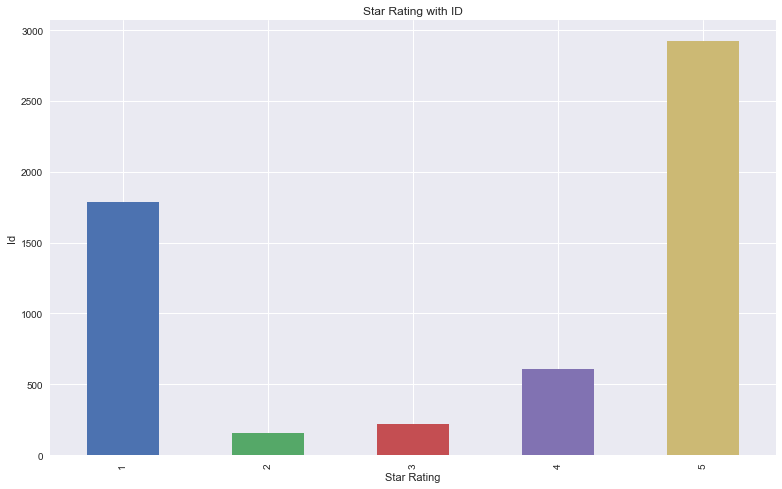

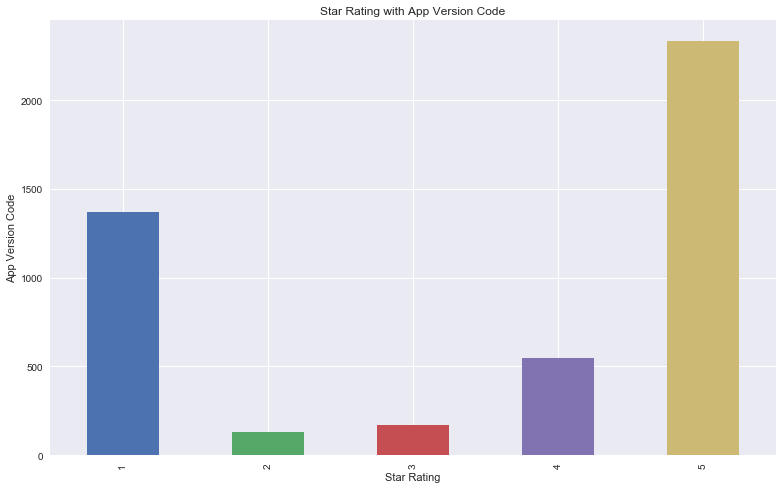

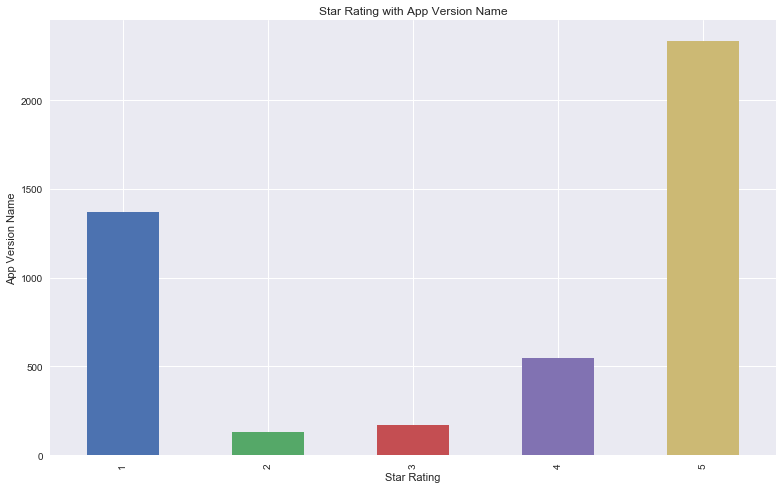

In [246]:
#Star Rating with ID
df.groupby("Star Rating")['id'].count().plot.bar()
plt.title("Star Rating with ID")
plt.ylabel("Id")
plt.show()

#Star Rating with App Version Code
df.groupby("Star Rating")['App Version Code'].count().plot.bar()
plt.title("Star Rating with App Version Code")
plt.ylabel("App Version Code")
plt.show()

#Star Rating with App Version Name
df.groupby("Star Rating")['App Version Name'].count().plot.bar()
plt.title("Star Rating with App Version Name")
plt.ylabel("App Version Name")
plt.show()



### Correlation between Ratings

Correlation b/w Rating                   App Version Code  App Version Name
App Version Code          1.000000          0.950719
App Version Name          0.950719          1.000000


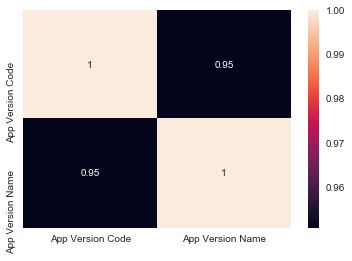

In [296]:
stars = df.groupby('Star Rating').mean()
print("Correlation b/w Rating",stars.corr())
sns.heatmap(data=stars.corr(), annot=True)

### Feature Engineering
- Adding features like Count of Words,Questions,URL,Emoji.

In [297]:
def count_regex(pattern, tweet):
        return len(re.findall(pattern, tweet))

df['Review Text']=df['Review Text'].astype(str)
df['Review Length'] = df['Review Text'].apply(len)
df['Review CntWrd']=df['Review Text'].apply(lambda x: count_regex(r'\w+', x)) 
df['Review CntMention']=df['Review Text'].apply(lambda x: count_regex(r'@\w+', x)) 
df['Review Question']=df['Review Text'].apply(lambda x: count_regex(r'!|\?', x)) 
df['Review URL']=df['Review Text'].apply(lambda x: count_regex(r'http.?://[^\s]+[\s]?', x)) 
df['Review Emoji']=df['Review Text'].apply(lambda x: emoji.demojize(x)).apply(lambda x: count_regex(r':[a-z_&]+:', x))
df['Review Emoji1']=df['Review Text'].apply(lambda x: emoji.demojize(x)) 
#print(re.findall(r'[^\w\s,]', df['Review Text'][21]))

print(df.head())

                                     id  App Version Code  App Version Name  \
0  b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9               NaN               NaN   
1  c7844e8f-56c1-487b-ae3e-df2fdf4c1767              43.0              2.30   
2  93ff57f7-9e02-4fa9-b779-3db82b8af0a4              52.0              2.12   
3  df2dcdef-c09a-4f35-afab-e1231d3fec9a              62.0              2.21   
4  11f8f968-4cec-4424-8427-9709ab05b5be              69.0              2.28   

                                         Review Text  Review Title  \
0                   Very bad wallet balance not use.           NaN   
1  Froud app i recharge 199 but not done also sen...           NaN   
2                       Waste to write comments also  Waste no use   
3                                           Nice apo           NaN   
4                                      Good nice app           NaN   

   Star Rating  Review Length  Review CntWrd  Review CntMention  \
0            1             32        

### Preprocessing of Data

In [291]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x,"lxml")
        x = example1.get_text()
    
    output = TextBlob(x).correct()
    # remove stop words
    stop = stopwords.words('english')
    #for i in range(0,5693):
    #    if x.split() not in stop:
    #        x=x
    
    return x
print(df.head())
df['Review Text']=df['Review Text'].fillna("").apply(preprocess)
print(df.head())

                                     id  App Version Code  App Version Name  \
0  b817b0f0-a2f8-4c9d-a5f6-d3fbf8b1d7e9               NaN               NaN   
1  c7844e8f-56c1-487b-ae3e-df2fdf4c1767              43.0              2.30   
2  93ff57f7-9e02-4fa9-b779-3db82b8af0a4              52.0              2.12   
3  df2dcdef-c09a-4f35-afab-e1231d3fec9a              62.0              2.21   
4  11f8f968-4cec-4424-8427-9709ab05b5be              69.0              2.28   

                                         Review Text  Review Title  \
0                   very bad wallet balance not use            NaN   
1  froud app i recharge 199 but not done also sen...           NaN   
2                       waste to write comments also  Waste no use   
3                                           nice apo           NaN   
4                                      good nice app           NaN   

   Star Rating  Review Length  Review CntWrd  Review CntMention  \
0            1             32        

### EDA
- Frequency of words(most common,most uncommon)
- Frequency of words with ratings (most common,most uncommon)
- Review Length with Star Rating

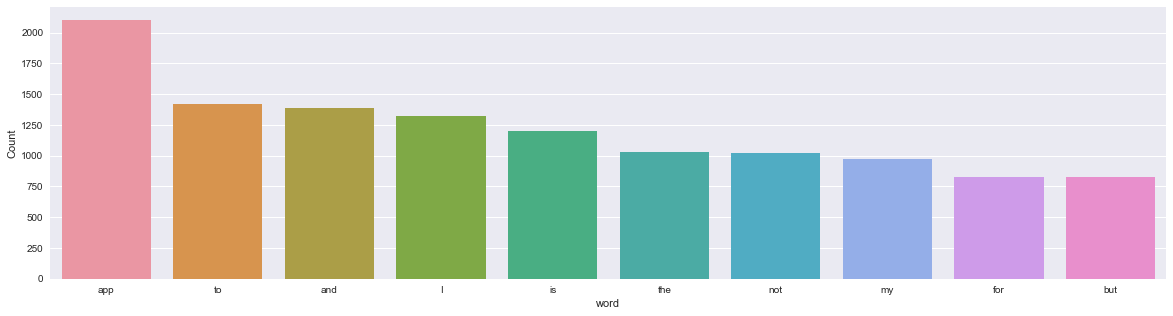

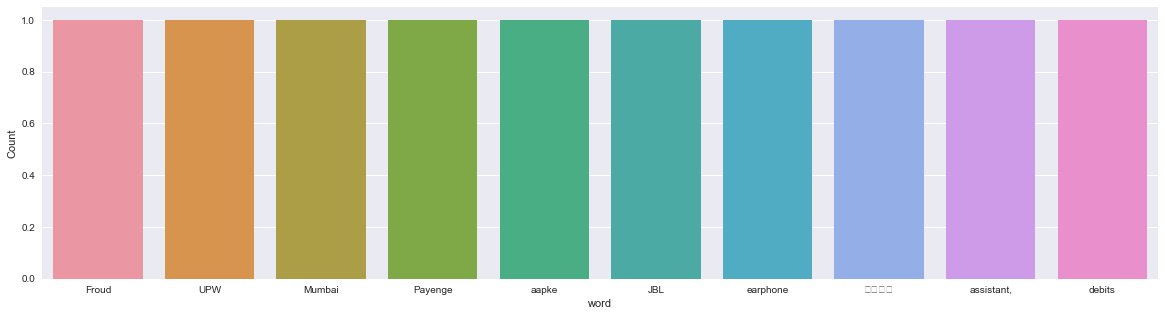

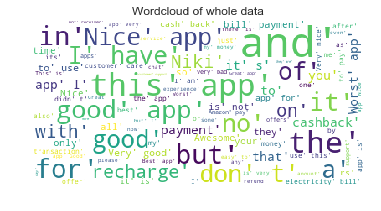

WordCloud of Rating 1


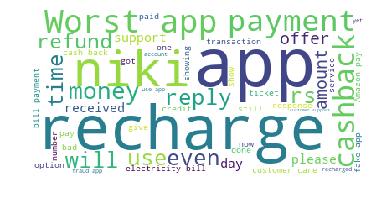

WordCloud of Rating 2


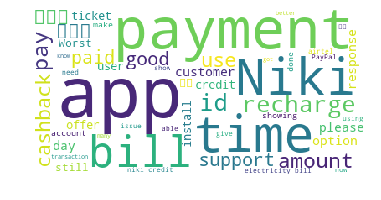

WordCloud of Rating 3


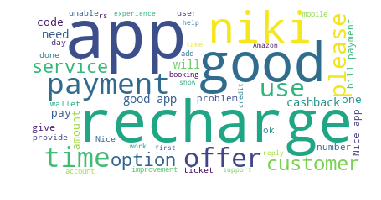

WordCloud of Rating 4


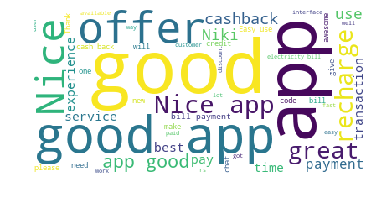

WordCloud of Rating 5


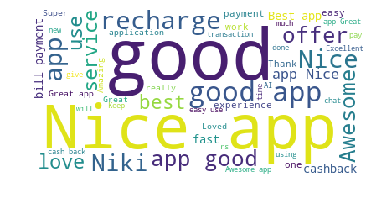

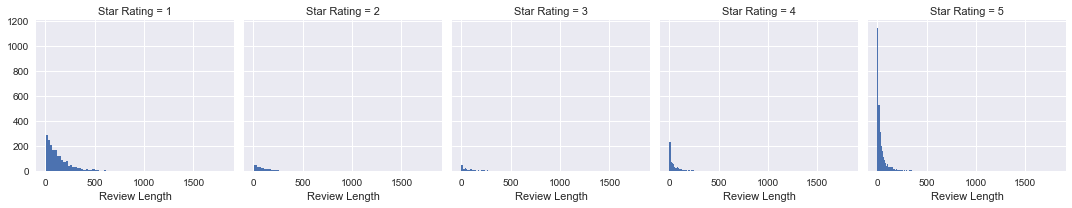

In [311]:
# function to plot most frequent terms
def freq_words(x, terms = 10):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

def freq_words1(x, terms = 10):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  # selecting last 20 most frequent words
  d = words_df.nsmallest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()


freq_words(df['Review Text'])
freq_words1(df['Review Text'])


#Wordcloud
corpus = []
for i in range(0, 5693):
    #Remove punctuations
    text = re.sub('[^a-zA-Z]', ' ', df['Review Text'][i])
    corpus.append(text.split())
stop = stopwords.words('english')
    
wordcloud = WordCloud(
                          background_color='white',
                          stopwords=stop,
                          max_words=100,
                          max_font_size=50, 
                          random_state=42
                         ).generate(str(corpus))
print(wordcloud)
fig = plt.figure(1)
plt.imshow(wordcloud)
plt.axis('off')
plt.title("Wordcloud of whole data")
plt.show()

#Wordcloud with Ratings
for i in range(1,6):
    train_ = df[df['Star Rating'] == i]

    # Combine all reviews for the desired 
    combined_text = " ".join(train_['Review Text'])

    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=50,
            # update stopwords to include common words like film and movie
            stopwords = STOPWORDS.update(['br','film','movie']))

    # Generate and plot wordcloud
    plt.imshow(wc.generate(combined_text))
    print("WordCloud of Rating",i)
    plt.axis('off')
    plt.show()

#Review Length with Star Rating
g = sns.FacetGrid(data=df, col='Star Rating')
g.map(plt.hist, 'Review Length', bins=50)



### Bi Grams

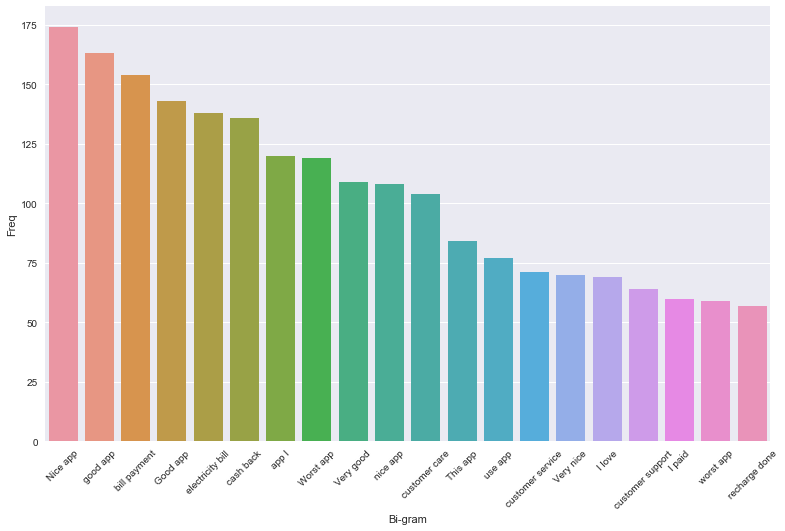

In [312]:
fig.savefig("word1.png", dpi=900)
#Most frequently occuring Bi-grams
def get_top_n2_words(corpus, n=None):
    vec1 = CountVectorizer(stop_words= stop, tokenizer=lambda doc: doc, lowercase=False, ngram_range=(2,2),max_features=2000).fit(corpus)
    bag_of_words = vec1.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     
                  vec1.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], 
                reverse=True)
    return words_freq[:n]

top2_words = get_top_n2_words(corpus, n=20)
top2_df = pd.DataFrame(top2_words)
top2_df.columns=["Bi-gram", "Freq"]
#Barplot of most freq Bi-grams
sns.set(rc={'figure.figsize':(13,8)})
h=sns.barplot(x="Bi-gram", y="Freq", data=top2_df)
h.set_xticklabels(h.get_xticklabels(), rotation=45)
plt.show()


### TF IDF
### Word 2 Vec
### Avg Word 2 Vec

In [354]:
cnt_vec=CountVectorizer(ngram_range=(1,2))
final_cnts=cnt_vec.fit_transform(df['Review Text'].values).toarray()
print(final_cnts)
print(final_cnts.shape)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(5693, 36482)


In [356]:
tfidf = TfidfVectorizer(lowercase=False,ngram_range=(1,2) )
final_cnts1=tfidf.fit_transform(df['Review Text'].values).toarray()
print(len(tfidf.get_feature_names()))
print(final_cnts1)
# dict key:word and value:tf-idf score
word2tfidf = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

40939
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [341]:
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300-SLIM.bin', binary=True)
print(model.wv.most_similar('woman'))
words=model.wv.vocab
print(len(words))

C:\Users\hp\Anaconda31\lib\site-packages\ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  after removing the cwd from sys.path.
C:\Users\hp\Anaconda31\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('man', 0.7664012312889099), ('girl', 0.7494640946388245), ('teenager', 0.631708562374115), ('lady', 0.6288787126541138), ('mother', 0.607630729675293), ('policewoman', 0.6069462299346924), ('boy', 0.5975908041000366), ('Woman', 0.5770983099937439), ('she', 0.5641393661499023), ('WOMAN', 0.5480420589447021)]


C:\Users\hp\Anaconda31\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


299567


In [357]:
print(words)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [ ]:
# storing the final features to csv file
df3_q1 = pd.DataFrame(final_cnts.tolist(), index= df.index)
df3_q2 = pd.DataFrame(final_cnts1.tolist(), index= df.index)
df3_q1['id']=df['id']
df3_q2['id']=df['id']
df2  = df3_q1.merge(df3_q2, on='id',how='left')
result  = df.merge(df2, on='id',how='left')
result.to_csv('final_features.csv')

In [323]:
from nltk.tokenize import word_tokenize
import gensim

SIZE = 50
df['clean_text'] = df['Review Text'].apply(lambda x : word_tokenize(x))
model = gensim.models.Word2Vec(df['clean_text'], min_count=1
, size=SIZE
, window=5
, workers=4)
model.most_similar('good', topn=3)


C:\Users\hp\Anaconda31\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  # Remove the CWD from sys.path while we load stuff.
C:\Users\hp\Anaconda31\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('nice', 0.9999765753746033),
 ('bad', 0.9998425841331482),
 ('very', 0.99980229139328)]

### Models
- 
-
-

In [ ]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    labels = [1,2]
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

#Random Model
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)


#Logistic Regression
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)



#xgboost
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4
d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)
watchlist = [(d_train, 'train'), (d_test, 'valid')]
bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)
xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)


In [ ]:
#LSTM
from keras.layers import Dense, Flatten, Dropout,Bidirectional
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.wrappers import TimeDistributed
from keras.layers.convolutional import (Conv2D,MaxPooling2D)
import csv     

#LRCN
#TimeDistributed Layer:It essentially makes the dense nodes of the layer identical 
#i.e. they all have the same weights and biases.

with open('data.csv', 'r') as fin: 
            reader = csv.reader(fin)
            data_file = list(reader)
        
#Dependent Variable classes
classes = []
for item in data_file:
            if item[1] not in classes:
                classes.append(item[1])

#Activation function used:Relu
#Weight Initializer :  he_normal  
model = Sequential()
input_shape=(80,80,3)
model.add(TimeDistributed(Conv2D(32, (7, 7), strides=(2, 2),
activation='relu', padding='same'), input_shape=input_shape))
model.add(TimeDistributed(Conv2D(32, (3,3),
kernel_initializer="he_normal", activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(64, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(64, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(128, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(128, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(256, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(256, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Conv2D(512, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(Conv2D(512, (3,3),
padding='same', activation='relu')))
model.add(TimeDistributed(MaxPooling2D((2, 2), strides=(2, 2))))

model.add(TimeDistributed(Flatten()))

model.add(Dropout(0.5))
#Bidirectional LSTM are used with 0.5 dropout
model.add(Bidirectional(LSTM(256, return_sequences=False, dropout=0.5)))
model.add(Dense(classes, activation='softmax'))

# Now compile the network.
#Optimizer use: Adam(It would be a non convex loss function)
opt= Adam(lr=1e-5, decay=1e-6)
#Loss Function for multiple classes: Crossentropy
model.compile(loss='categorical_crossentropy', optimizer=opt)
print(model.summary())




### Modifications that can be done:
- Machine Transaltion using Seq 2 Seq models (Convert hindi text to english).
- Conversion of abbrevations.